<a href="https://colab.research.google.com/github/5dongdong/PY_AI/blob/master/model/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
df = pd.read_csv('/content/drive/MyDrive/data/medical_noshow3.csv')  

In [145]:
df

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,AwaitingTime,Num_App_Missed,Gender_F,Gender_M
0,62,0,1,0,0,0,0,1,0,0,0,0,0.776481,0,1,0
1,56,0,0,0,0,0,0,1,0,0,0,0,0.672535,0,0,1
2,62,0,0,0,0,0,0,1,0,0,0,0,0.679907,0,1,0
3,8,0,0,0,0,0,0,1,0,0,0,0,0.728831,0,1,0
4,56,0,1,1,0,0,0,1,0,0,0,0,0.671794,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442071,56,0,0,0,0,1,0,1,0,0,0,0,34.614178,1,1,0
442072,51,0,0,0,0,1,0,1,0,0,0,0,34.689201,1,1,0
442073,21,0,0,0,0,1,0,1,0,0,0,0,40.330648,0,1,0
442074,38,0,0,0,0,1,0,1,0,0,0,0,40.368484,0,1,0


In [146]:
x = df[['Age',	'Scholarship',	'Hipertension',	'Diabetes',	'Alcoholism',	'SMS_received',	'Handicap_0',	'Handicap_1',	'Handicap_2',	'Handicap_3',	'Handicap_4',	'AwaitingTime',	'Num_App_Missed',	'Gender_F',	'Gender_M']]
# x = df[['Age',	'AwaitingTime',	'Num_App_Missed']]
y = df[['No-show']]   
# df = df.drop('Handicap_0', axis=1)
# df = df.drop('Handicap_2', axis=1)
# df = df.drop('Handicap_3', axis=1)
# df = df.drop('Handicap_4', axis=1)

x_train, x_test, y_train,y_test = train_test_split(
    x, y, train_size=0.8, shuffle=True, random_state=42
)
     

In [147]:
df

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,AwaitingTime,Num_App_Missed,Gender_F,Gender_M
0,62,0,1,0,0,0,0,1,0,0,0,0,0.776481,0,1,0
1,56,0,0,0,0,0,0,1,0,0,0,0,0.672535,0,0,1
2,62,0,0,0,0,0,0,1,0,0,0,0,0.679907,0,1,0
3,8,0,0,0,0,0,0,1,0,0,0,0,0.728831,0,1,0
4,56,0,1,1,0,0,0,1,0,0,0,0,0.671794,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442071,56,0,0,0,0,1,0,1,0,0,0,0,34.614178,1,1,0
442072,51,0,0,0,0,1,0,1,0,0,0,0,34.689201,1,1,0
442073,21,0,0,0,0,1,0,1,0,0,0,0,40.330648,0,1,0
442074,38,0,0,0,0,1,0,1,0,0,0,0,40.368484,0,1,0


In [148]:
# 변수 설정
n_splits = 5    # 보통 홀수로 들어감
random_state = 42
scaler = QuantileTransformer()

In [149]:
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, 
              random_state=random_state)


# Scaler
scaler.fit(x_train)                 
x_train = scaler.transform(x_train)   # train 은 fit, transform 모두 해줘야 함
x_test = scaler.transform(x_test) 

In [150]:
param = {
    'num_leaves':[10, 20, 31],
    'max_depth':[5, 7, 8],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'feature_fraction':[0.5, 0.7, 0.8],
    'bagging_fraction':[0.5, 0.7, 0.8],
    'lambda_l1, lambda_l2':[1, 5, 10]
}
#bagging_fraction': (bagging_fraction=0.5, feature_fraction=0.7, lambda_l1, lambda_l2=10, learning_rate=0.2, max_depth=5, n_estimators=200, num_leaves=20)

In [151]:
# 2. 모델
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

model = LGBMClassifier(num_leaves=51, max_depth=6, learning_rate=0.05803173560581885, 
                       n_estimators=742, feature_fraction=0.8501371667493939,
                       bagging_fraction=0.5816189510532447, 
                       lambda_l1=1.1300532616287016, lambda_l2=1.1300532616287016)

# model = GridSearchCV(light, param, cv=kfold, verbose=1,
#                       refit=True, n_jobs=-1)

# 3.훈련
model.fit(x_train, y_train)

# print('최적의 파라미터 : ', model.best_params_)
# print('최적의 매개변수 : ', model.best_estimator_)
# print('best_score : ', model.best_score_)
# print('model score : ', model.score(x_test, y_test))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


LGBMClassifier(bagging_fraction=0.5816189510532447,
               feature_fraction=0.8501371667493939,
               lambda_l1=1.1300532616287016, lambda_l2=1.1300532616287016,
               learning_rate=0.05803173560581885, max_depth=6, n_estimators=742,
               num_leaves=51)

In [152]:


#4. 평가, 예측
result = model.score(x_test,y_test)

score = cross_val_score( model, 
                        x_train, y_train,
                        cv = kfold )  #cv = cross validation_

y_predict = cross_val_predict(model,
                              x_test, y_test,
                              cv = kfold)

acc = accuracy_score(y_test, y_predict)

print('결과 acc : ', result)
print('cv pred acc : ', acc )


# LGBMClassifier(bagging_fraction=0.5, feature_fraction=0.7, lambda_l1=10,
#                lambda_l2=10, learning_rate=0.2, max_depth=5, n_estimators=200,
#                num_leaves=20)
# 결과 acc :  0.9204216431415129
# cv pred acc :  0.9182500904813609


# LGBMClassifier(feature_fraction=0.6, max_depth=10, min_data_in_leaf=50,
#                n_estimators=200, num_leaves=32, reg_alpha=0.1, reg_lambda=0.01)
# 결과 acc :  0.9207383279044516
# cv pred acc :  0.9152642055736518

#===================================================================
# LGBMClassifier(bagging_fraction=0.5, feature_fraction=0.5, lambda_l1=10,
#                lambda_l2=10, max_depth=8)
# 결과 acc :  0.9201501990589939
# cv pred acc :  0.9188382193268186

# x3
# 결과 acc :  0.9237129026420557
# cv pred acc :  0.9220389974665218

#==================================================================
# LGBMClassifier(bagging_fraction=0.4089910928350561,
#                feature_fraction=0.022621757234206785,
#                lambda_l1=1.127987668851632, lambda_l2=1.127987668851632,
#                learning_rate=0.07949705772341571, max_depth=7,
#                n_estimators=1751, num_leaves=49)
# 결과 acc :  0.9192453854505972
# cv pred acc :  0.9181143684401013

#==================================================================
# x3
# LGBMClassifier(bagging_fraction=0.5816189510532447,
#                feature_fraction=0.8501371667493939,
#                lambda_l1=1.1300532616287016, lambda_l2=1.1300532616287016,
#                learning_rate=0.05803173560581885, max_depth=6, n_estimators=742,
#                num_leaves=51)
# 결과 acc :  0.9276714621787912
# cv pred acc :  0.9236563517915309

# QuantileTransformer
# 결과 acc :  0.9284066232356135
# cv pred acc :  0.9241087585957293

# StandardScaler
# 결과 acc :  0.9281464893231994
# cv pred acc :  0.9237920738327905

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] lambda_l1 is set=1.1300532616287016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300532616287016
[LightGBM] [Warning] feature_fraction is set=0.8501371667493939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8501371667493939
[LightGBM] [Warning] lambda_l2 is set=1.1300532616287016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1300532616287016
[LightGBM] [Warning] bagging_fraction is set=0.5816189510532447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816189510532447
결과 acc :  0.9284066232356135
cv pred acc :  0.9241087585957293


In [153]:
from sklearn.feature_selection import SelectFromModel

thresholds = model.feature_importances_

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    print(select_x_train.shape, select_x_test.shape)

    selection_model = LGBMClassifier(feature_fraction=0.6, max_depth=10, min_data_in_leaf=50, n_estimators=200, num_leaves=32, reg_alpha=0.1, reg_lambda=0.01)
    selection_model.fit(select_x_train, y_train)
    y_predict = selection_model.predict(select_x_test)
    score = accuracy_score(y_test, y_predict)
    print("Thresh=%.3f, n=%d, acc:%.2f%%"
        %(thresh, select_x_train.shape[1], score*100)) 

(353660, 1) (88416, 1)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=10030.000, n=1, acc:80.01%
(353660, 8) (88416, 8)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=428.000, n=8, acc:92.27%
(353660, 4) (88416, 4)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=654.000, n=4, acc:92.06%
(353660, 6) (88416, 6)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=579.000, n=6, acc:92.26%
(353660, 9) (88416, 9)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=303.000, n=9, acc:92.24%
(353660, 5) (88416, 5)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=627.000, n=5, acc:92.19%
(353660, 11) (88416, 11)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=192.000, n=11, acc:92.29%
(353660, 12) (88416, 12)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=176.000, n=12, acc:92.29%
(353660, 13) (88416, 13)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=52.000, n=13, acc:92.33%
(353660, 15) (88416, 15)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=0.000, n=15, acc:92.33%
(353660, 15) (88416, 15)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=0.000, n=15, acc:92.33%
(353660, 2) (88416, 2)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=9698.000, n=2, acc:80.02%
(353660, 3) (88416, 3)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=3125.000, n=3, acc:92.19%
(353660, 7) (88416, 7)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=504.000, n=7, acc:92.26%
(353660, 10) (88416, 10)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Thresh=258.000, n=10, acc:92.31%


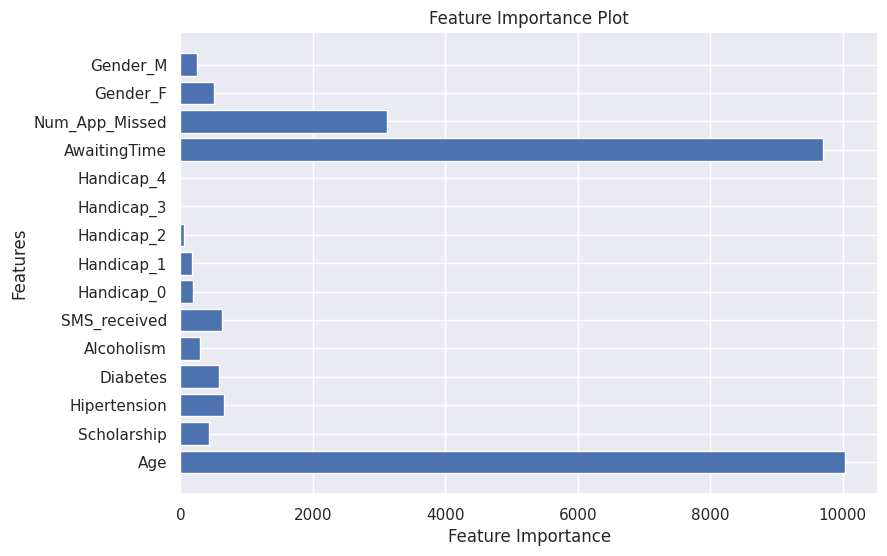

In [154]:
import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
fig, ax = plt.subplots()
ax.barh(x.columns, feature_importances)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance Plot')
plt.show()